In [88]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder

In [89]:
df = pd.read_csv("./data/training_set_metadata.csv")
selected_features = ['ra', 'decl', 'gal_l', 'gal_b', 'ddf', 'hostgal_specz', 'hostgal_photoz', 'distmod', 'mwebv', 'target']

In [90]:
df = pd.DataFrame(df, columns = selected_features)
df.head(5)

,ra,decl,gal_l,gal_b,ddf,hostgal_specz,hostgal_photoz,distmod,mwebv,target
0,349.046051,-61.943836,320.796530,-51.753706,1,0.0000,0.0000,NaN,0.017,92
1,53.085938,-27.784405,223.525509,-54.460748,1,1.8181,1.6267,45.4063,0.007,88
2,33.574219,-6.579593,170.455585,-61.548219,1,0.2320,0.2262,40.2561,0.021,42
3,0.189873,-45.586655,328.254458,-68.969298,1,0.3037,0.2813,40.7951,0.007,90
4,352.711273,-63.823658,316.922299,-51.059403,1,0.1934,0.2415,40.4166,0.024,90


In [91]:
num_targets = df['target'].nunique() # 14 classes of objects as it had been written in docs

In [92]:
unique_targets = df['target'].unique() # unique classes
encoder = LabelEncoder()
unique_targets = encoder.fit_transform(unique_targets)

In [93]:
map_dictionary = dict(zip(encoder.classes_, unique_targets))
map_dictionary

{6: 12,
 15: 10,
 16: 3,
 42: 11,
 52: 8,
 53: 2,
 62: 9,
 64: 13,
 65: 6,
 67: 1,
 88: 4,
 90: 0,
 92: 7,
 95: 5}

In [144]:
def count_by_value(df, col = 'target', class_numbers = 14):
    unique_targets = df['target'].values
    list_counters = [0] * class_numbers
    for target in unique_targets:
        number_of_target = df[col][df[col] == target].value_counts().values
        mapped_index = map_dictionary[target]
        list_counters[mapped_index] = number_of_target[0]
    return np.array(list_counters)

In [145]:
counter_list = count_by_value(df)

In [154]:
def plot_histogram(X , Y):
    plt.style.use("dark_background")
    plt.figure(figsize=(16, 10))
    plt.xlabel("Object class mapped from oryginal")
    plt.ylabel("The number of the object in the dataset")
    plt.title("Checking ")
    plt.bar(X, Y, label = "The number of a particular astronimical object")

No handles with labels found to put in legend.


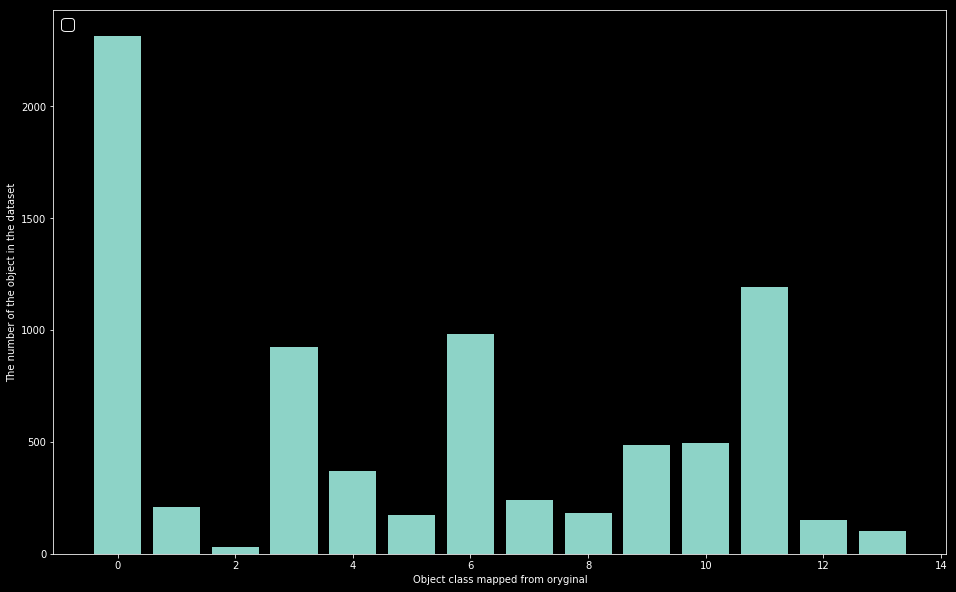

In [155]:
plot_histogram(list(range(0, 14)), counter_list)